# Czech Republic

In [2]:
import pandas as pd
import geopandas as gpd
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

pd.options.mode.chained_assignment = None
%config InlineBackend.figure_format = 'retina'

## Fetch results

In [2]:
def get_districts():
    url = 'https://www.volby.cz/pls/ep2014/ep13?xjazyk=CZ'
    r = requests.get(url)
    html = BeautifulSoup(r.text)
    tds = html.select('.table td.center')
    links = [x.select_one('a')['href'] for x in tds 
             if x.select_one('a')['href'].startswith('ep133')]
    return links

In [12]:
def get_municipalities(url):
    base_url = 'https://www.volby.cz/pls/ep2014/'
    url = f'{base_url}/{url}'
    r = requests.get(url)
    html = BeautifulSoup(r.text)
    links = html.select('td.cislo > a')
    links = [x['href'] for x in links if x['href'].startswith('ep1311')]
    return links

In [18]:
def get_turnout(url):
    base_url = 'https://www.volby.cz/pls/ep2014'
    url = f'{base_url}/{url}'
    r = requests.get(url)
    html = BeautifulSoup(r.text)
    crumbs = get_crumbs(html)
    turnout = pd.read_html(r.text, header=1)[0].iloc[0]['Volebníúčast v %']
    return (crumbs, turnout)

In [22]:
def get_crumbs(html):
    return html.select_one('p.drobek').text

In [13]:
%%time
municipalities = []

for district in get_districts():
    m = get_municipalities(district)
    municipalities.extend(m)

CPU times: user 3.78 s, sys: 108 ms, total: 3.89 s
Wall time: 26.2 s


In [26]:
%%time
results = []

for mun in municipalities:
    turnout = get_turnout(mun)
    results.append(turnout)

CPU times: user 5min 52s, sys: 10.4 s, total: 6min 3s
Wall time: 39min 23s


In [36]:
df = pd.DataFrame(results, columns=['crumbs', 'turnout'])

In [40]:
df.turnout = df.turnout.astype(str).apply(lambda x: f'{x[:2]}.{x[2:]}').astype(float)

In [65]:
df = pd.concat([df, df.crumbs.str.split(' > ', expand=True)], axis=1)
df = df.drop(['crumbs', 0, 1, 2], axis=1)
df = df.rename(columns={3: 'district', 4: 'municipality'})
df.district = df.district.str.strip()
df.municipality = df.municipality.str.strip()
df['id'] = municipalities
df.id = df.id.str.extract('&xobec=(\d+)&')

In [8]:
df.to_csv('../../data/raw/cze.csv', index=False)

In [5]:
df = pd.read_csv('../../data/raw/cze.csv', dtype={'id': str})

## Merge

In [44]:
geo = gpd.read_file('../../data/shapefiles/cze/OBCE_P.shp', encoding='cp1250')

In [46]:
geo = geo.to_crs(epsg=4326)

In [47]:
geo = geo.merge(df, left_on='KOD', right_on='id', how='left')

In [76]:
# From website
geo.loc[lambda x: x.NAZEV == 'Praha', 'turnout'] = 25.82
# From website
geo.loc[lambda x: x.NAZEV == 'Ostrava', 'turnout'] = 15.47
# https://www.volby.cz/pls/ep2014/ep1311?xjazyk=CZ&xnumnuts=3203
geo.loc[lambda x: x.NAZEV == 'Plzeň', 'turnout'] = 15.47
# https://www.volby.cz/pls/ep2014/ep1311?xjazyk=CZ&xnumnuts=6202
geo.loc[lambda x: x.NAZEV == 'Brno', 'turnout'] = 21.78
# Did not exist in 2014, see https://cs.wikipedia.org/wiki/Lubom%C4%9B%C5%99_pod_Str%C3%A1%C5%BEnou
# https://www.volby.cz/pls/ep2014/ep1311?xjazyk=CZ&xnumnuts=7102
geo.loc[lambda x: x.NAZEV == 'Luboměř pod Strážnou', 'turnout'] = 17.24
# Did not exist in 2014, see https://cs.wikipedia.org/wiki/M%C4%9Bsto_Libav%C3%A1
# https://www.volby.cz/pls/ep2014/ep1311?xjazyk=CZ&xobec=503941&xvyber=7102
geo.loc[lambda x: x.NAZEV == 'Město Libavá', 'turnout'] = 15.73
# Did not exist in 2014, see https://cs.wikipedia.org/wiki/Doupovsk%C3%A9_Hradi%C5%A1t%C4%9B
# https://www.volby.cz/pls/ep2014/ep1311?xjazyk=CZ&xobec=555177&xvyber=4102
geo.loc[lambda x: x.NAZEV == 'Doupovské Hradiště', 'turnout'] = 14.98
# Did not exist in 2014, see https://cs.wikipedia.org/wiki/Poln%C3%A1_na_%C5%A0umav%C4%9B
# https://www.volby.cz/pls/ep2014/ep1311?xjazyk=CZ&xobec=545422&xvyber=3102
geo.loc[lambda x: x.NAZEV == 'Polná na Šumavě', 'turnout'] = 8.1
# Did not exist in 2014, see https://cs.wikipedia.org/wiki/Bra%C5%BEec_(okres_Karlovy_Vary)
# https://www.volby.cz/pls/ep2014/ep1311?xjazyk=CZ&xobec=555177&xvyber=4102
geo.loc[lambda x: x.NAZEV == 'Bražec', 'turnout'] = 14.98
# Did not exist in 2014, see https://cs.wikipedia.org/wiki/Kozlov_(okres_Olomouc)
# https://www.volby.cz/pls/ep2014/ep1311?xjazyk=CZ&xobec=503941&xvyber=7102
geo.loc[lambda x: x.NAZEV == 'Kozlov', 'turnout'] = 15.73

## Export

In [80]:
geo = geo[['NAZEV', 'turnout', 'geometry']]
geo = geo.rename(columns={'NAZEV': 'name'})

In [81]:
geo['country'] = 'cze'

In [83]:
geo.to_file('../../data/processed/cze', encoding='utf8')

## Visualize

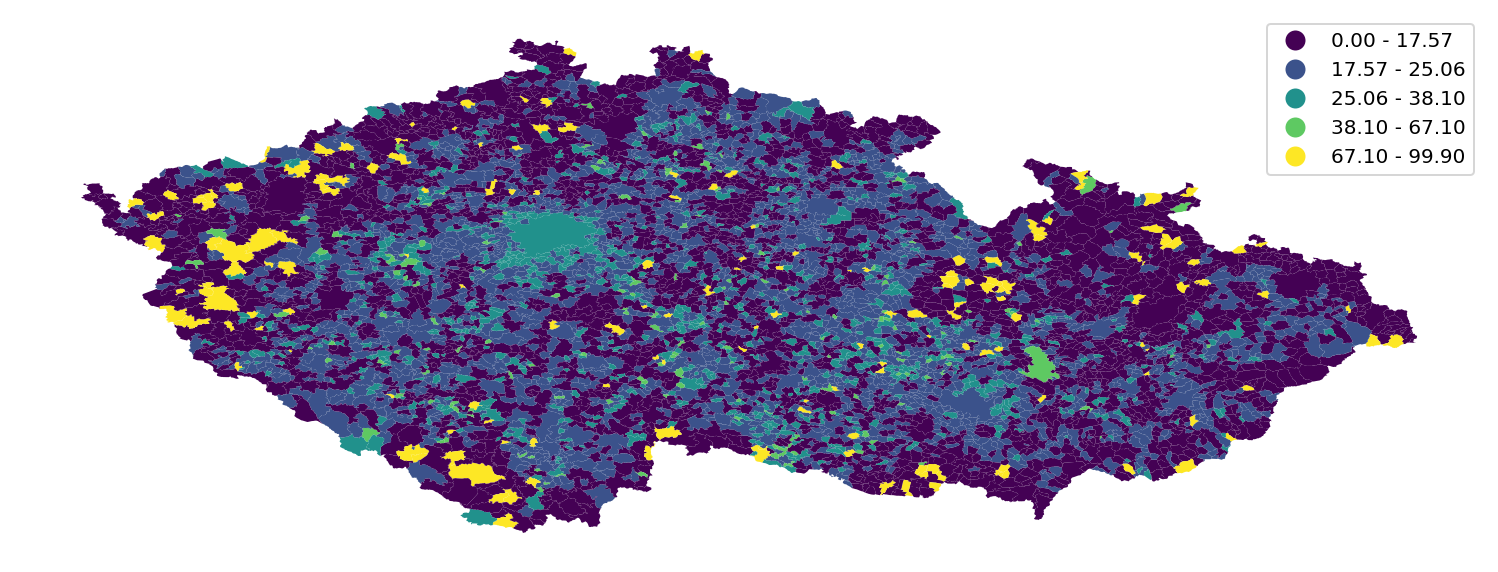

In [91]:
ax = geo.plot(figsize=(16, 5), column='turnout', legend=True, scheme='Fisher_Jenks');
fig = ax.get_figure()
fig.set_facecolor('#ffffff')
ax.set_axis_off()
fig.savefig('../../reports/cze_choropleth.png')